## Sieci neuronowe - wprowadzenie

Poniżej znajduje się implementacja prostej sieci neuronowej dla problemu klasyfikacji binarnej na przykładzie losowo wygenerowanego zestawu danych.

W sieciach jednokierunkowych (ang. _feedforward_) wartości neuronów w $i$-tej warstwie są obliczane na podstawie wartości neuronów warstwy $i-1$. Mając daną $n$-warstwową sieć neuronową oraz jej parametry $\Theta^{(1)}, \ldots, \Theta^{(n)} $ oraz $\beta^{(1)}, \ldots, \beta^{(n)}$ liczymy: 

$$a^{(i)} = g^{(i)}\left( a^{(i-1)} \Theta^{(i)} + \beta^{(i)} \right). $$

Gdzie $g^{(i)}$ to tzw. **funkcje aktywacji**

### Zadania

1. (15 pkt.) Rozwiń rekurencję dla poniższej sieci neuronowej, zapisując równania (w postaci Latexowej) dla $a^{(i)}$, wskaż funkcje aktywacji dla każdej warstwy oraz funkcję decyzyjną dla klasyfikacji. Podaj rozmiary wszystkich warstw oraz wymiary macierzy $\theta^{(i)}$ i $\beta^{(i)}$.

1. (10 pkt.) Zaimplementuj funkcję `accuracy` i podaj końcową skuteczność klasyfikacji. Dodatkowo, skuteczność wypisuj wraz z wartością funkcji kosztu podczas trenowania modelu.

1. (10 pkt.) Zbuduj sieci neuronowe dla różnych wielkości warstwy ukrytej $n=1,2,3,5,10,25$. Narysuj krzywe decyzyjne dla każdego modelu. Jakie zależności zaobserwowałeś?

1. (15 pkt.) Zastosuj poniższą implementację sieci neuronowej do klasyfikacji binarnej zbioru wygenerowanego za pomocą wybranej funkcji [sklearn.datasets](http://scikit-learn.org/stable/modules/classes.html#samples-generator). Ustal rozmiary warstw wejściowej ($n \gt 2$) i ukrytej, dobierz odpowiednie parametry sieci (parametr $\alpha$, liczba epok, wielkość warstwy ukrytej). Narysuj funkcję decyzyjną i podaj skuteczność klasyfikacji.

In [1]:
import numpy as np
from sklearn import datasets
import matplotlib
import matplotlib.pyplot as plt
import itertools
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

def generate_data():
    # Keep results deterministic
    np.random.seed(1234)
    X, y = datasets.make_moons(200, noise=0.25)
    # X, y = datasets.make_classification(200, 2, 2, 0)
    return X, y

def visualize(X, y, model=None, plot=False):
    if plot:
        fig = plot
    else:
        fig = plt.figure()
        
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    if model:
        Z = predict(model, np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.viridis)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.viridis)
    if not plot:
        plt.show()

def initialize_model(dim_in=2, dim_hid=3, dim_out=2):
    # Keep results deterministic
    np.random.seed(1234)
    W1 = np.random.randn(dim_in, dim_hid) / np.sqrt(dim_in)
    b1 = np.zeros((1, dim_hid))
    W2 = np.random.randn(dim_hid, dim_out) / np.sqrt(dim_hid)
    b2 = np.zeros((1, dim_out))
    return W1, b1, W2, b2

def softmax(X):
    e = np.exp(X)
    return e / np.sum(e, axis=1, keepdims=True)

def predict(model, X):
    W1, b1, W2, b2 = model
    
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    probs = softmax(z2)
    return np.argmax(probs, axis=1)

def calculate_cost(model, X, y):
    W1, b1, W2, b2 = model
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    probs = softmax(z2)
    preds = probs[:, 1]
    return -1. / len(y) * np.sum(
        np.multiply(y, np.log(preds)) + np.multiply(1 - y, np.log(1 - preds)),
        axis=0)

def accuracy(model, X, y):
    acc = 0.0
    for i in range(len(y)):
        cls = predict(model, X[i]).item()
        correctCls = int(y[i].item())
        
        acc += correctCls == cls
    return acc / len(X)

def train(model, X, y, alpha=0.01, epochs=10000, debug=False):
    W1, b1, W2, b2 = model
    m = len(X)

    for i in range(epochs):
        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        probs = softmax(z2)

        # Backpropagation
        delta3 = probs
        delta3[range(m), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Parameter update
        W1 -= alpha * dW1
        b1 -= alpha * db1
        W2 -= alpha * dW2
        b2 -= alpha * db2

        # Print loss
        if debug and i % 1000 == 0:
            model = (W1, b1, W2, b2)
            print("Cost after iteration {}: {:.4f}, accuracy: {:.4f}".format(i, 
                                                                             calculate_cost(model, X, y), 
                                                                             accuracy(model, X, y)))

    return W1, b1, W2, b2

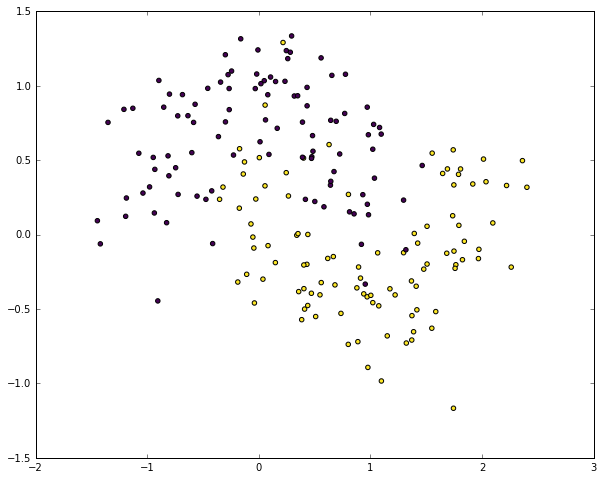

In [2]:
X, y = generate_data()
visualize(X, y)

Cost after iteration 0: 0.5868, accuracy: 0.6950
Cost after iteration 1000: 0.1542, accuracy: 0.9500
Cost after iteration 2000: 0.1512, accuracy: 0.9500
Cost after iteration 3000: 0.1498, accuracy: 0.9500
Cost after iteration 4000: 0.1515, accuracy: 0.9450
Cost after iteration 5000: 0.1521, accuracy: 0.9450
Cost after iteration 6000: 0.1525, accuracy: 0.9450
Cost after iteration 7000: 0.1529, accuracy: 0.9450
Cost after iteration 8000: 0.1532, accuracy: 0.9450
Cost after iteration 9000: 0.1535, accuracy: 0.9450


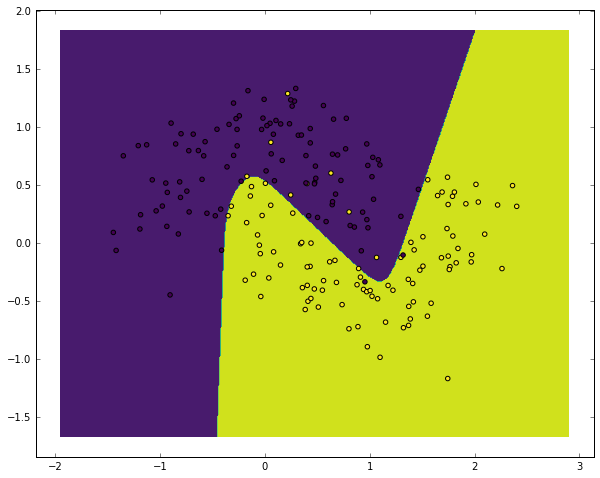

In [3]:
model = train(initialize_model(), X, y, debug=True)
visualize(X, y, model)

### Zadanie 1

$$a^{(1)} = g^{(1)}\left( a^{(0)} \Theta^{(1)} + \beta^{(1)} \right) = g^{(1)}\left( X \Theta^{(1)} + \beta^{(1)} \right)$$
$$a^{(2)} = g^{(2)}\left( a^{(1)} \Theta^{(2)} + \beta^{(2)} \right)$$

$g^{(1)}$ - tanges hiperboliczny ($tanh$), natomiast $g^{(2)}$ to softmax. Funkcją decyzyjną jest argmax. 

W danym przykładzie sieć składa się z trzech warstw: wejściowej (domyślnie o rozmiarze 2), ukrytej (domyslnie rozmiaru 3) oraz wyjściowej (o domyślnym rozmiarze 2).

Dla powyższych wartości:

$\beta^{(1)} \in {\rm I\!R}^3$ (czyli 1x3), $\beta^{(2)} \in {\rm I\!R}^2$ (czyli 1x2).

$\Theta^{(1)} \in {\rm I\!R}^{2 \times 3}$ (2x3), $\Theta^{(2)} \in {\rm I\!R}^{3 \times 2}$ (3x2).

### Zadanie 2

In [4]:
print("Model accuracy %.4f" % accuracy(model, X, y))

Model accuracy 0.9450


### Zadanie 3

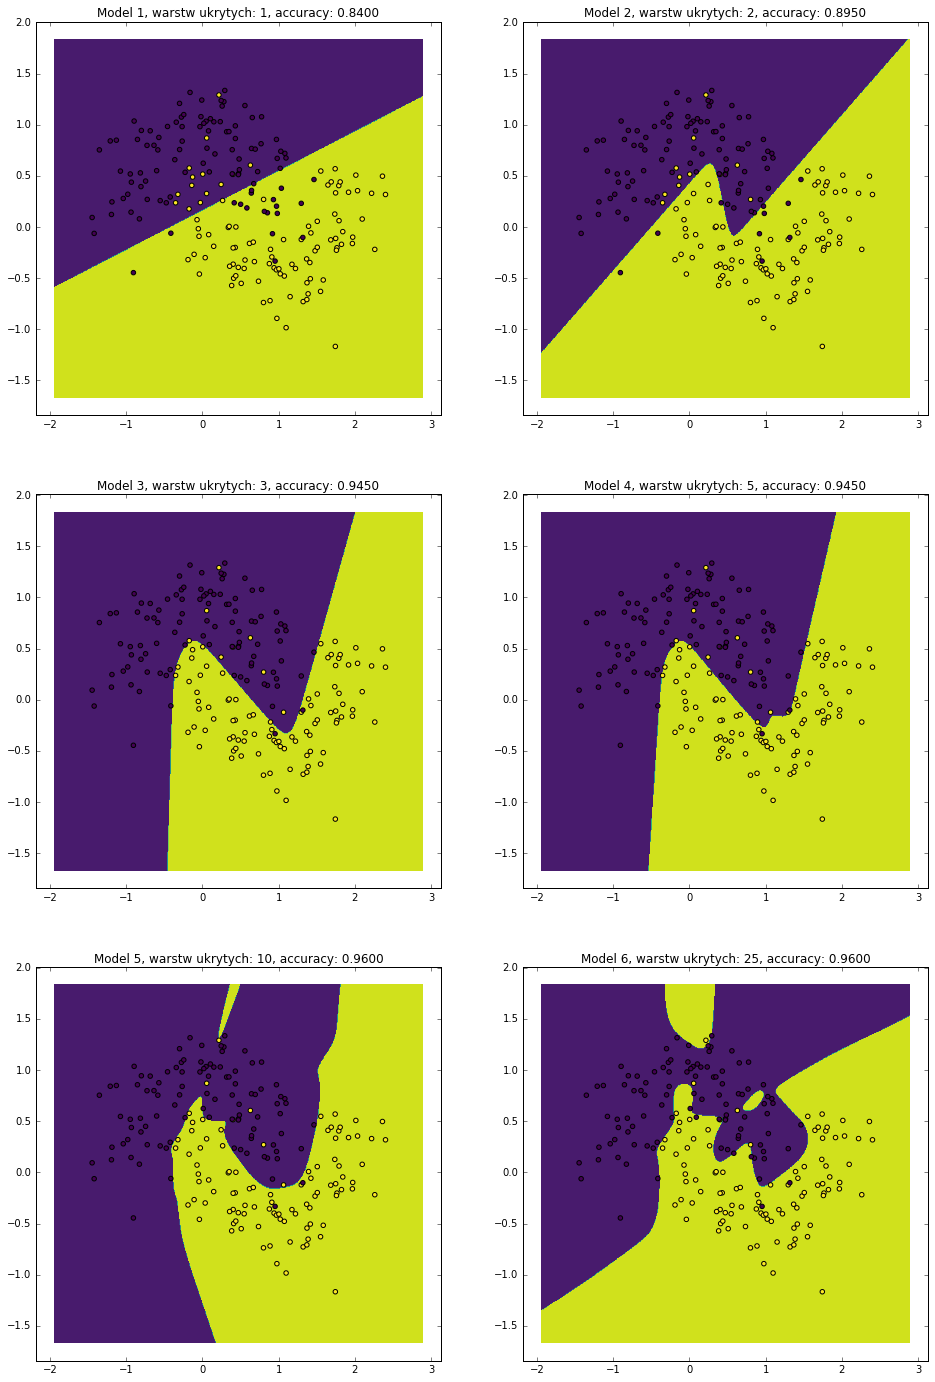

In [5]:
fig = plt.figure(figsize=(16, 24))
hidden_layers = [1, 2, 3, 5, 10, 25]
for i, hidden_layer in enumerate(hidden_layers):
    plt.subplot(3, 2, i+1)
    model = train(initialize_model(dim_hid=hidden_layer), X, y, debug=False)
    acc = accuracy(model, X, y)
    plt.title("Model %d, warstw ukrytych: %d, accuracy: %.4f" % (i+1, hidden_layer, acc))
    visualize(X, y, model, fig)
plt.show()

Im warstwa ukryta większa, tym model lepiej dopasowuje się do danych. Jak widać, nie wpływa to bardzo na accuracy. Przy wysokich  rozmiarach warstwy ukrytej istnieje ryzyko overfittingu.

### Zadanie 4

In [6]:
def get_models(dim_in, parameters, X_train, X_test, y_train, y_test, debug=False):
    results = []
    for i, parameter in enumerate(parameters):
        alpha, epoch, hidden_layer = parameter
        model = train(initialize_model(dim_in=dim_in, dim_hid=hidden_layer), X_train, y_train, alpha=alpha, epochs=epoch, debug=False)
        
        acc = accuracy(model, X_test, y_test)
        results.append((parameter, acc, model))
        if debug:
            print(i)
    return results

For 5 features the best accuracy: 0.9200 for parameters: [(0.001, 1000, 25)]


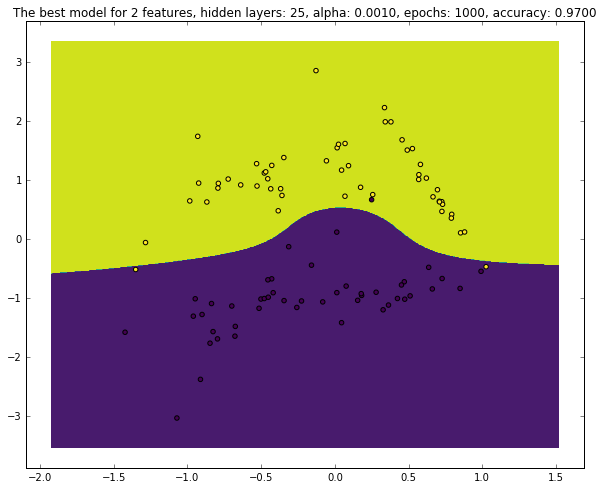

In [7]:
X, y = datasets.make_classification(n_samples=500, n_features=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

alphas = [0.1, 0.01, 0.05, 0.001]
epochs = [1000, 10000, 100000]
hidden_layers = [1, 3, 5, 10, 25]
results = []

parameters = list(itertools.product(alphas, epochs, hidden_layers))
results = get_models(5, parameters, X_train, X_test, y_train, y_test, debug=False)
best_acc = max(results, key = lambda item:item[1])[1]
best_results = [x[0] for x in results if x[1] == best_acc]
print("For 5 features the best accuracy: %.4f for parameters: %s" % (best_acc, best_results))

X_new = SelectKBest(f_classif, k=2).fit_transform(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2)
best_of = get_models(2, best_results, X_train, X_test, y_train, y_test, debug=False)
    
params, acc, model = max(best_of, key = lambda item:item[1])
alpha, epoch, hidden_layer = params

fig = plt.figure()
plt.title("The best model for 2 features, hidden layers: %d, alpha: %.4f, epochs: %d, accuracy: %.4f" % (hidden_layer, alpha, epoch, acc))
visualize(X_test, y_test, model, fig)
plt.show()